# Build k-means to find the tier type for each college
# ('ELITE', 'HIGH_SEL', 'LESS_SEL', 'MED_SEL', 'MOST_SEL', 'NON_SEL', 'SEL', 'OPEN_ADM')
# For example ELITE means  Admission is very difficult (only apply to isActive = 1)

In [4]:
import numpy as np
from matplotlib import cm
import pandas as pd

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns

In [5]:
sc = pd.read_csv("sc.csv")
sc = sc.drop(columns=["Unnamed: 0"])
sc.head()

,index,mykCollegeId,UNITID,undergraduateStudentsCount,graduateStudentsCount,totalStudentsCount,undergraduateGenderMaleFraction,undergraduateGenderFemaleFraction,undergraduateRaceWhiteFraction,undergraduateRaceNonWhiteFraction,...,admittedACTCombined50Percentile,admittedACTCombined75Percentile,updateDate,tuitionAvgIncomeUnder30k,tuitionAvgIncomeBetween30kAnd48k,tuitionAvgIncomeBetween48kAnd75k,tuitionAvgIncomeBetween75kAnd110k,tuitionAvgIncomeOver110k,highschoolGPA,tierKey
0,0,1001,100858.0,24209.0,5866.0,30075.0,0.5171,0.4829,0.8003,0.1997,...,22.75,25.0,2022-06-22,17866.0,19064.0,23468.0,25389.0,26300.0,3.85,HIGH_SEL
1,1,1002,100937.0,1205.0,NaN,NaN,0.4739,0.5261,0.7867,0.2133,...,NaN,NaN,2022-06-22,17186.0,18870.0,19226.0,20071.0,22268.0,3.69,SEL
2,2,1003,101073.0,389.0,NaN,389.0,0.4936,0.5064,0.0334,0.9178,...,NaN,NaN,2022-06-22,NaN,NaN,NaN,NaN,NaN,NaN,SEL
3,4,1005,107080.0,1104.0,12.0,1116.0,0.4783,0.5217,0.6078,0.3922,...,NaN,NaN,2022-06-22,12822.0,10861.0,18120.0,22802.0,27119.0,3.94,MOST_SEL
4,10,1011,129774.0,597.0,NaN,NaN,0.5662,0.4338,0.5176,0.4824,...,NaN,NaN,2022-06-22,24514.0,25182.0,25793.0,NaN,23699.0,2.68,SEL


Text(0.5, 0.98, 'Distribution of Races')

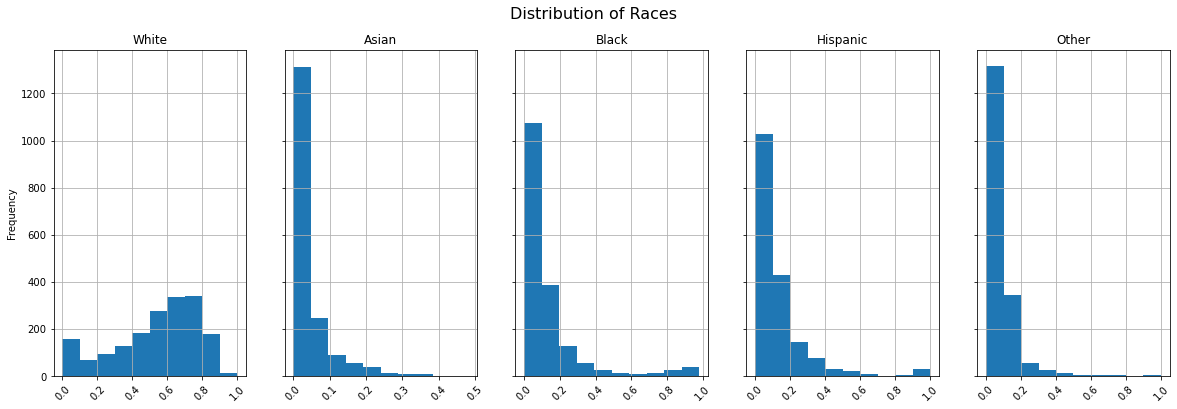

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)
sc['undergraduateRaceWhiteFraction'].plot(kind='hist', ax=axes[0], grid=True, rot=45, title="White")
sc['undergraduateRaceAsianFraction'].plot(kind='hist', ax=axes[1], grid=True, rot=45, title="Asian")
sc['undergraduateRaceBlackFraction'].plot(kind='hist', ax=axes[2], grid=True, rot=45, title="Black")
sc['undergraduateRaceHispanicFraction'].plot(kind='hist', ax=axes[3], grid=True, rot=45, title="Hispanic")
sc['undergraduateRaceOtherFraction'].plot(kind='hist', ax=axes[4], grid=True, rot=45, title="Other")
plt.suptitle('Distribution of Races', fontsize=16)

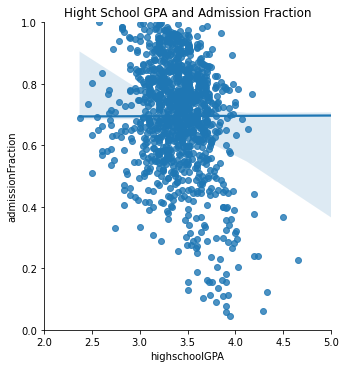

In [7]:
import seaborn as sns

fig = sns.lmplot(x="highschoolGPA", y="admissionFraction", data=sc, scatter=True)
fig.set(ylim=(0, 1), xlim=(2, 5))
plt.title("Hight School GPA and Admission Fraction")
plt.show()

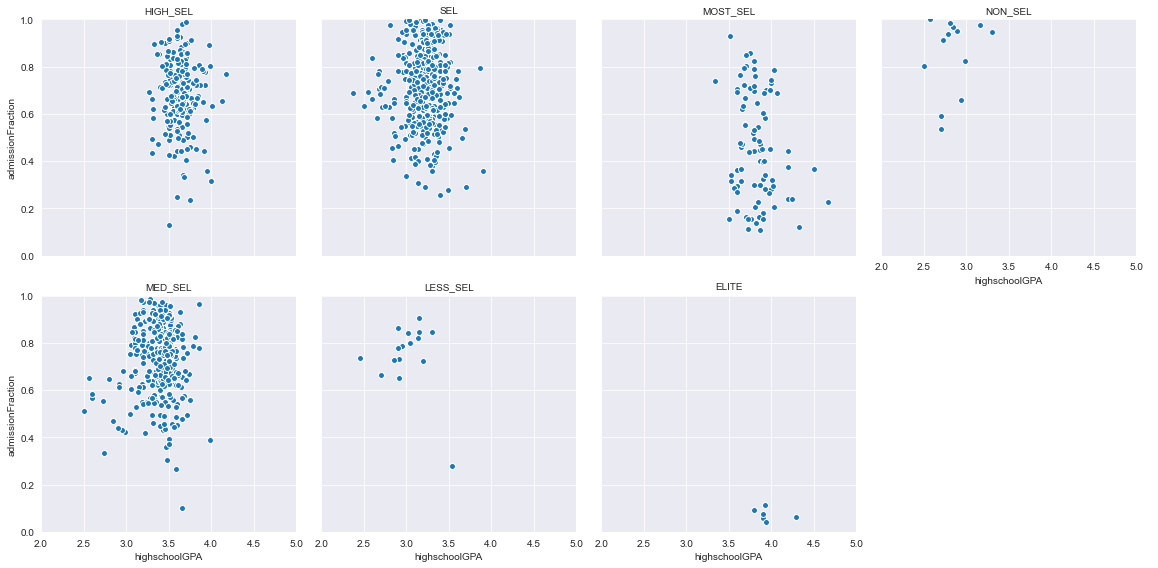

In [9]:
graph = sns.FacetGrid(sc, col ="tierKey", height=4, col_wrap=4) 
graph.set(ylim=(0, 1), xlim=(2, 5))
graph.map(plt.scatter, "highschoolGPA", "admissionFraction", edgecolor ="w").add_legend() 
graph.set_titles(col_template="{col_name}")
plt.show() 

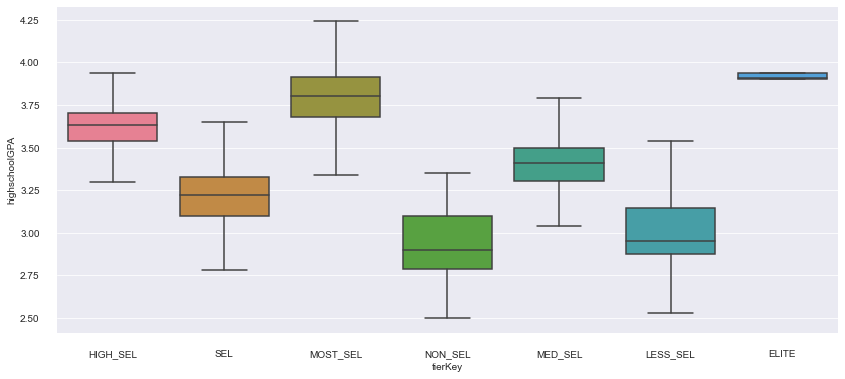

In [10]:
plt.figure(figsize=(14,6))
sns.boxplot(x='tierKey',y='highschoolGPA',data=sc, palette=sns.color_palette("husl",8+1), showfliers = False)
sns.despine(offset=10, trim=True)

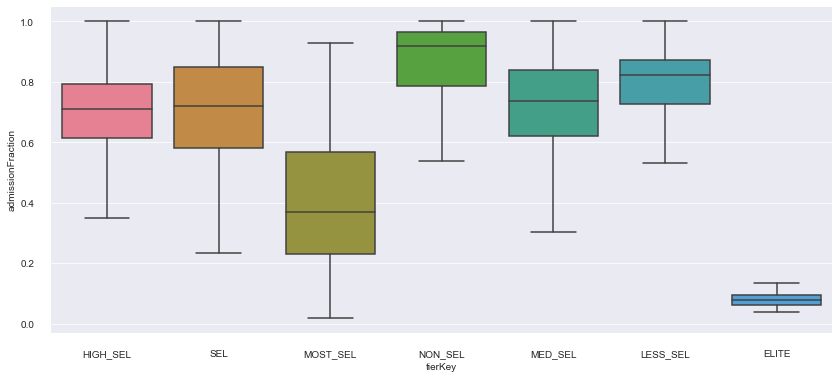

In [11]:
plt.figure(figsize=(14,6))
sns.boxplot(x='tierKey',y='admissionFraction',data=sc, palette=sns.color_palette("husl",8+1), showfliers = False)
sns.despine(offset=10, trim=True)

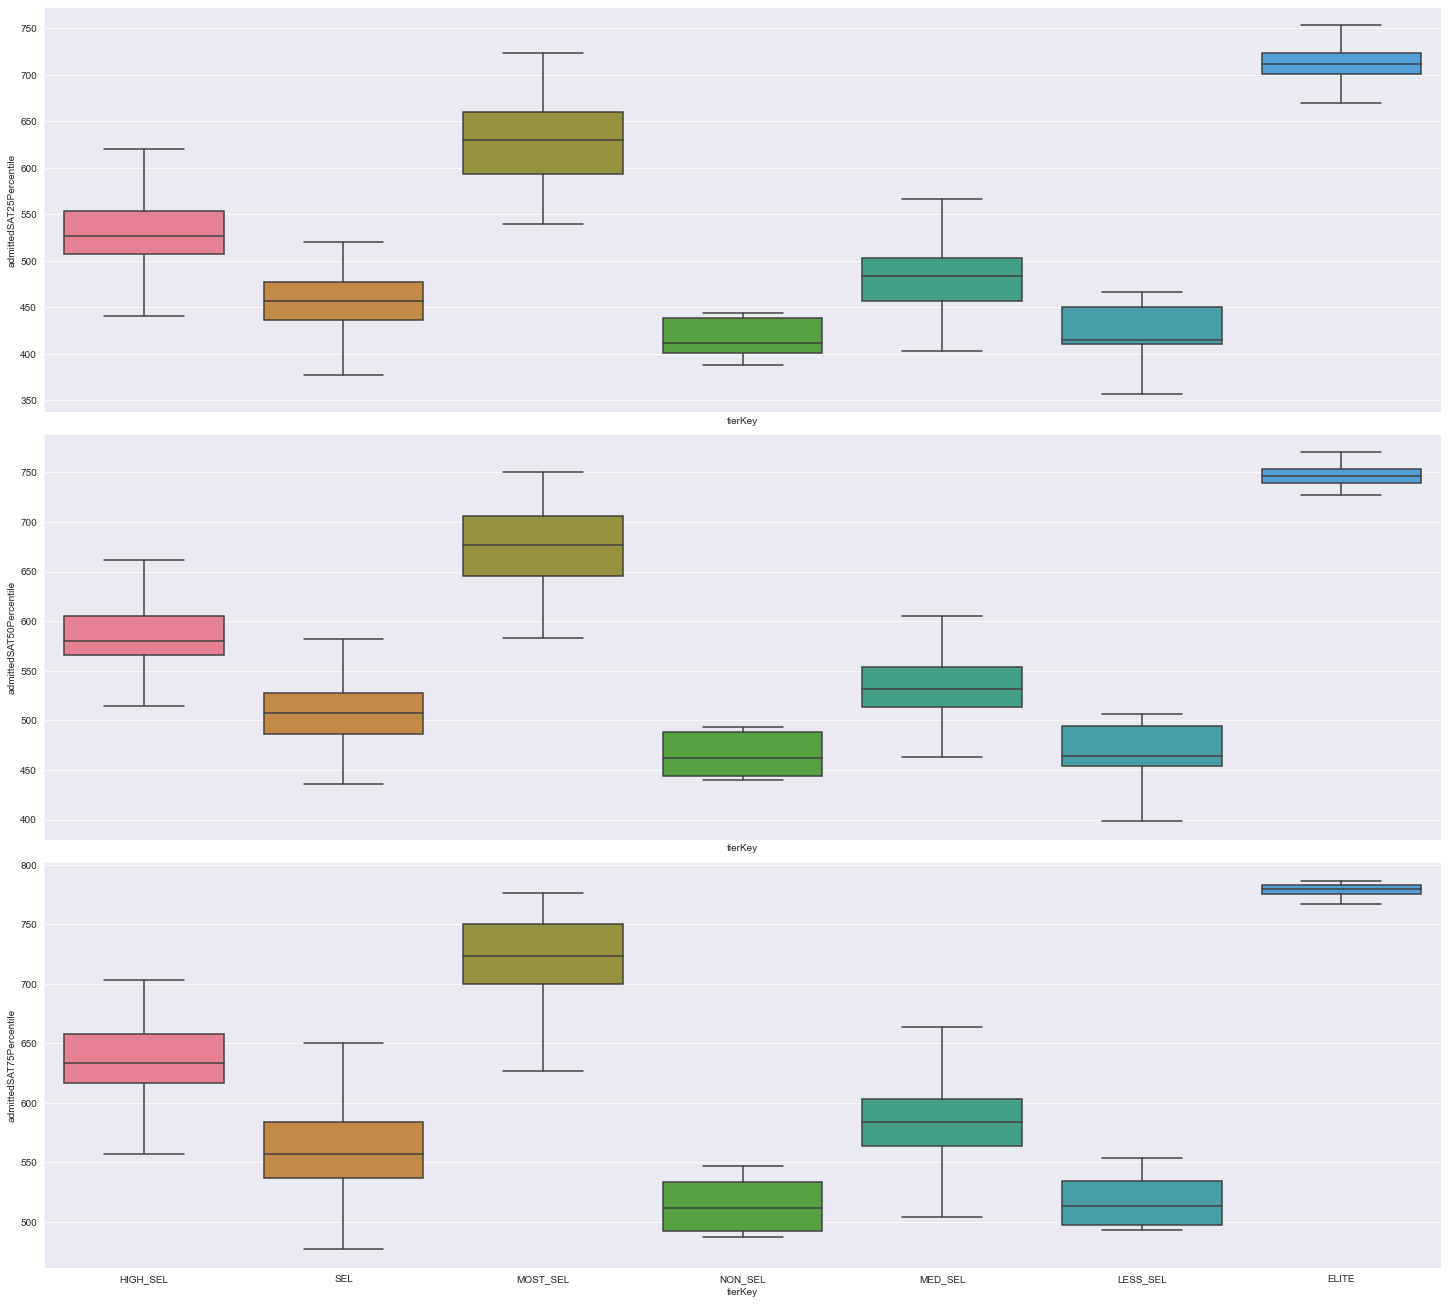

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18), sharex=True, constrained_layout=True)

for ax, c in enumerate(['admittedSAT25Percentile', 'admittedSAT50Percentile', 'admittedSAT75Percentile']):
    sns.boxplot(x='tierKey',y=c, data=sc[[c, 'tierKey']], palette=sns.color_palette("husl",8+1),
                showfliers = False, ax=axes[ax])

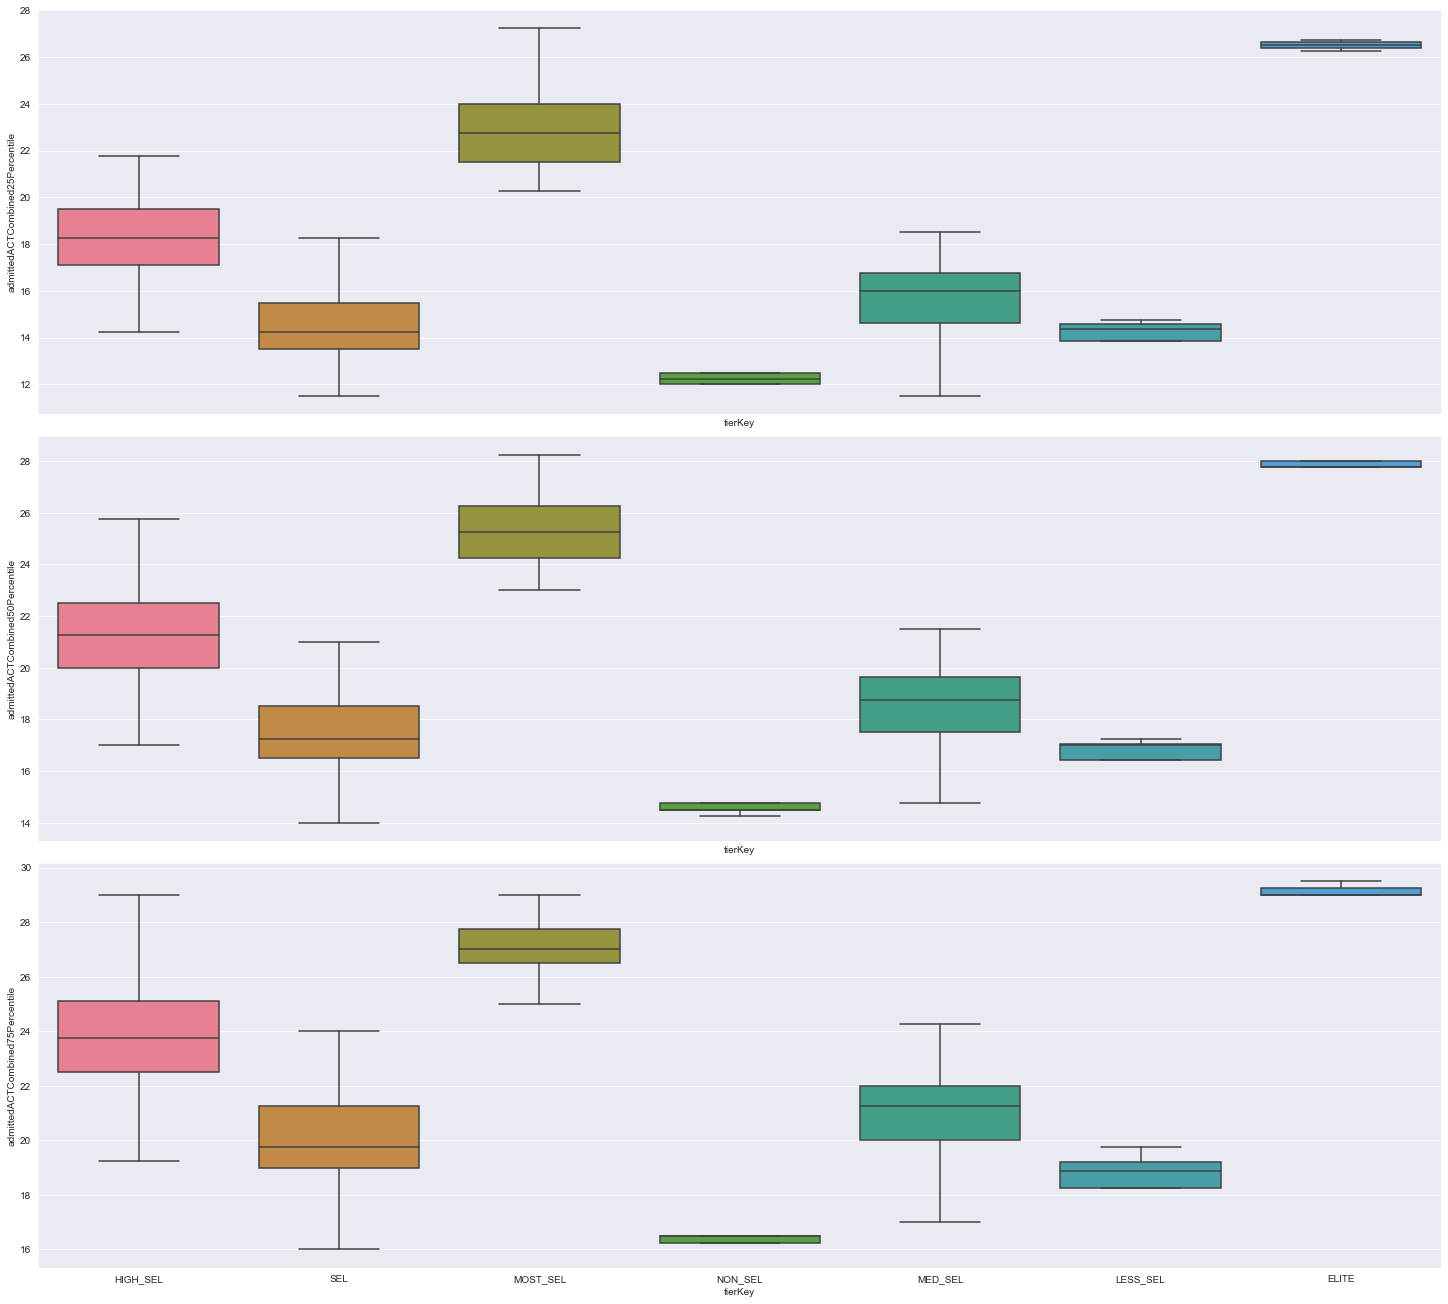

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18), sharex=True, constrained_layout=True)

for ax, c in enumerate(['admittedACTCombined25Percentile', 'admittedACTCombined50Percentile',
                        'admittedACTCombined75Percentile']):
    sns.boxplot(x='tierKey',y=c, data=sc[[c, 'tierKey']], palette=sns.color_palette("husl",8+1),
                showfliers = False, ax=axes[ax])

In [46]:
data = pd.read_csv("/Users/shenzongqi/Desktop/PythonProject/Work/MyKlovr/Archive/Model/data.csv",header=0,index_col=0)
data.head()

,admissionFraction,highschoolGPA,admittedSAT25Percentile,admittedSAT50Percentile,admittedSAT75Percentile,admittedACTCombined25Percentile,admittedACTCombined50Percentile,admittedACTCombined75Percentile,admissionRate,enrollRate,...,avgACT,percentFulltimeOffer6m,gradRate,medEarning,defaultRate,grades,Average_SAT,Average_ACT,Average_GPA,Average_Admission
arcoName,,,,,,,,,,,,,,,,,,,,,
AI Miami International University of Art and Design,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abilene Christian University,0.5806,3.64,1025.0,1123.0,1220.0,21.0,24.0,26.0,0.62,0.15,...,24.0,0.53,0.67,35600.0,0.05,B+,899.4,23.750000,3.625,0.6003
Abraham Baldwin Agricultural College,0.7021,NaN,920.0,1015.0,1110.0,17.0,20.0,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1015.0,19.666667,NaN,0.7021
Academy of Art University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.73,...,NaN,NaN,0.40,26900.0,0.06,B-,NaN,NaN,NaN,1.0000
Acadia University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data['Average_SAT'] = data[['admittedSAT25Percentile', 'admittedSAT50Percentile', 'admittedSAT75Percentile',
                            'avgSATmath', 'avgSATebrw']].mean(axis=1)
#data['Average_SAT'] = data[['avgSATmath', 'avgSATebrw']].mean(axis=1)
data['Average_ACT'] = data[['admittedACTCombined25Percentile', 'admittedACTCombined50Percentile',
                        'admittedACTCombined75Percentile', 'avgACT']].mean(axis=1)

data['Average_GPA'] = data[['avgGPA', 'highschoolGPA']].mean(axis=1)
#data['Average_GPA'] = data[['avgGPA']]
data['Average_Admission'] = data[['admissionFraction', 'admissionRate']].mean(axis=1)
#data['Average_Admission'] = data[['admissionRate']]
data.isna().sum()

admissionFraction                   320
highschoolGPA                       788
admittedSAT25Percentile             755
admittedSAT50Percentile             755
admittedSAT75Percentile             754
admittedACTCombined25Percentile     704
admittedACTCombined50Percentile     704
admittedACTCombined75Percentile     704
admissionRate                       601
enrollRate                          702
avgGPA                              785
avgSATmath                         1170
avgSATebrw                         1177
avgACT                              961
percentFulltimeOffer6m             1409
gradRate                            533
medEarning                          551
defaultRate                         538
grades                              529
Average_SAT                         635
Average_ACT                         560
Average_GPA                         597
Average_Admission                   282
dtype: int64

In [49]:
NotImpt = data[['Average_Admission', 'Average_GPA', 'Average_ACT', 'gradRate',
              'medEarning', 'defaultRate']].dropna()
NotImpt.shape

(1063, 6)

In [50]:
NotImpt[NotImpt['Average_GPA'] > 4]

,Average_Admission,Average_GPA,Average_ACT,gradRate,medEarning,defaultRate
arcoName,,,,,,
Appalachian State University,0.73500,4.235,25.000000,0.72,33000.0,0.04
Clemson University,0.49090,4.430,29.000000,0.83,43600.0,0.03
College of William and Mary,0.36960,4.235,31.000000,0.91,43900.0,0.01
Elon University,0.72265,4.010,27.000000,0.83,42200.0,0.01
Grambling State University,0.69885,46.005,18.000000,0.33,21900.0,0.18
Scripps College,0.32685,4.105,31.000000,0.88,40500.0,0.00
University of California-Davis,0.41180,4.025,28.666667,0.86,40400.0,0.02
University of California-Los Angeles,0.14050,4.115,31.500000,0.91,44500.0,0.01
University of California-San Diego,0.32995,4.040,29.500000,0.86,43400.0,0.02


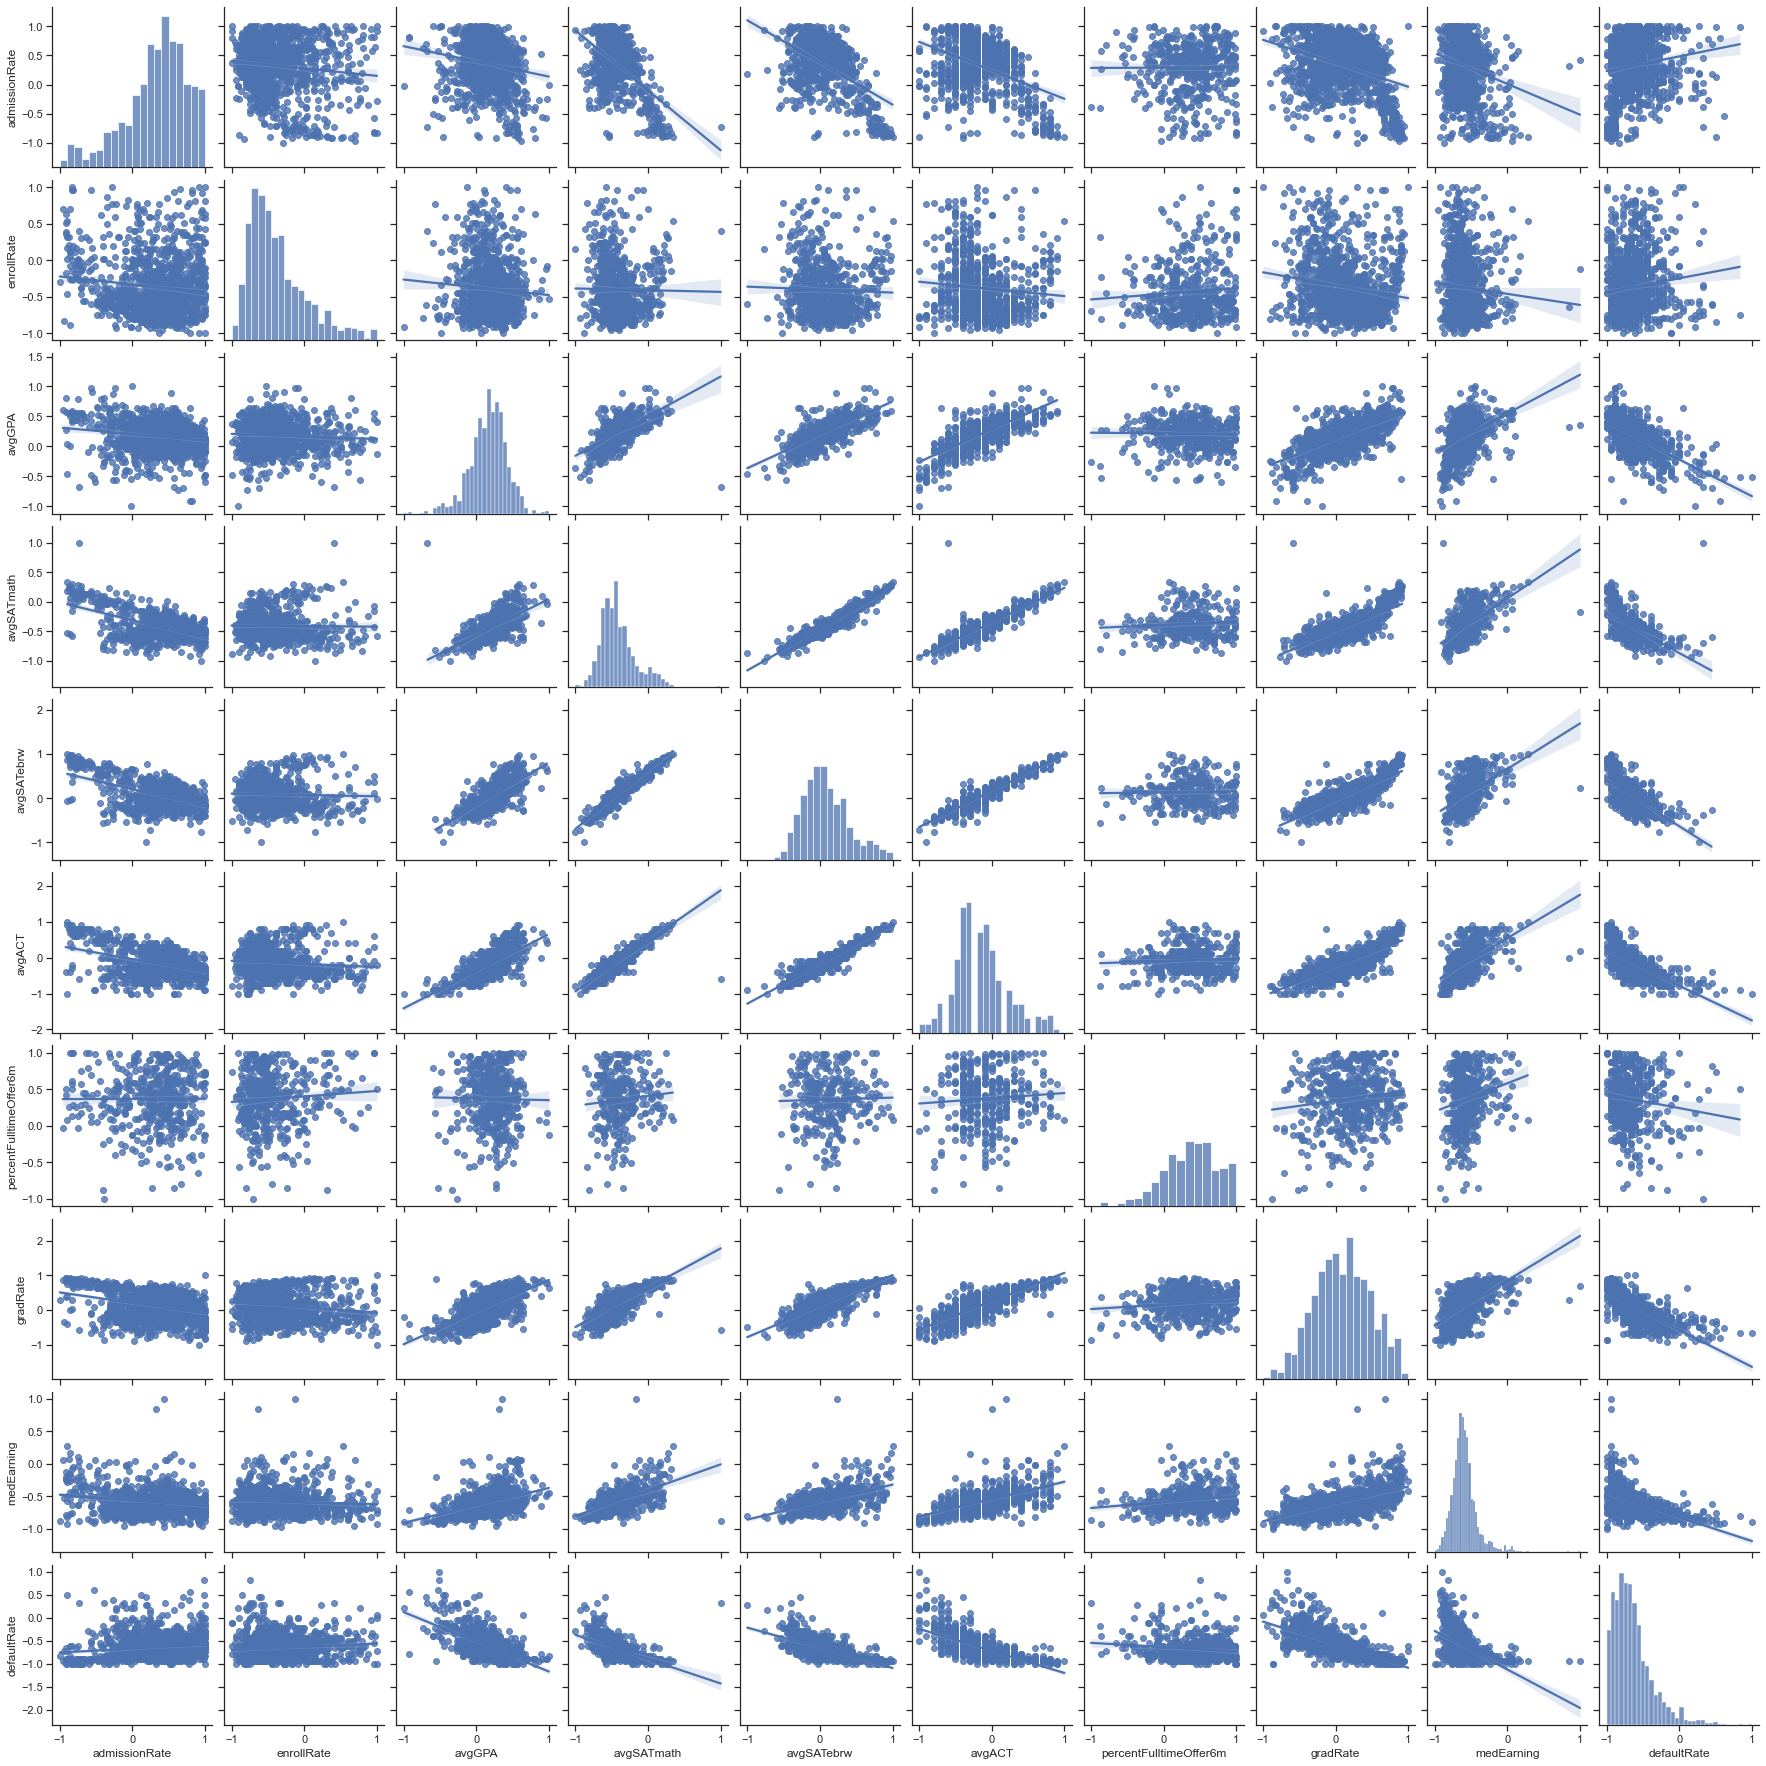

In [51]:
X_std = MinMaxScaler(feature_range=(-1, 1)).fit_transform(data[['admissionRate', 'enrollRate',
                                                                'avgGPA', 'avgSATmath', 'avgSATebrw', 'avgACT',
                                                                'percentFulltimeOffer6m', 'gradRate','medEarning',
                                                                'defaultRate']])

sns.set(style = "ticks", color_codes = True)
sns.pairplot(data = pd.DataFrame(X_std, columns=['admissionRate', 'enrollRate',
                                                 'avgGPA', 'avgSATmath', 'avgSATebrw', 'avgACT',
                                                 'percentFulltimeOffer6m', 'gradRate','medEarning',
                                                 'defaultRate']),
             kind = 'reg', dropna = True)
plt.show()

In [52]:
NotImpt

,Average_Admission,Average_GPA,Average_ACT,gradRate,medEarning,defaultRate
arcoName,,,,,,
Abilene Christian University,0.60030,3.625,23.75,0.67,35600.0,0.05
Adams State University,0.98940,3.125,19.75,0.27,26700.0,0.10
Adelphi University,0.73560,3.505,24.75,0.70,43500.0,0.04
Adrian College,0.57865,3.230,22.25,0.45,32100.0,0.08
Agnes Scott College,0.65290,3.790,27.00,0.69,30800.0,0.05
...,...,...,...,...,...,...
Yeshiva University,0.58910,3.445,26.00,0.83,41300.0,0.02
York College,0.54245,3.070,21.25,0.51,28400.0,0.17
York College of Pennsylvania,0.69450,3.480,22.50,0.59,38100.0,0.04


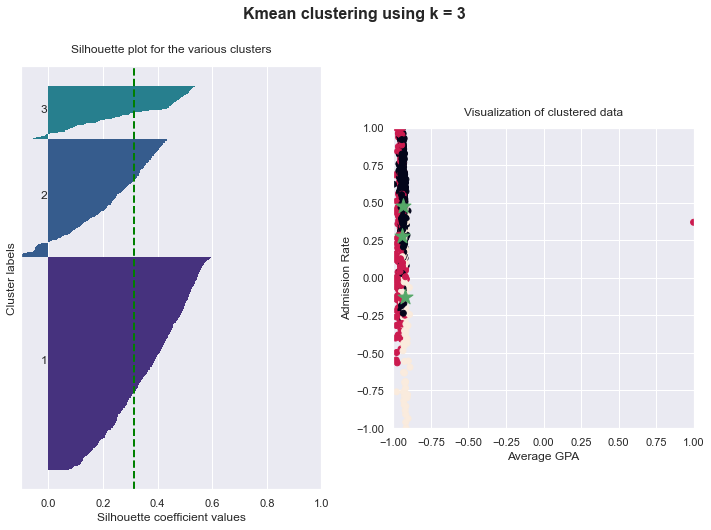

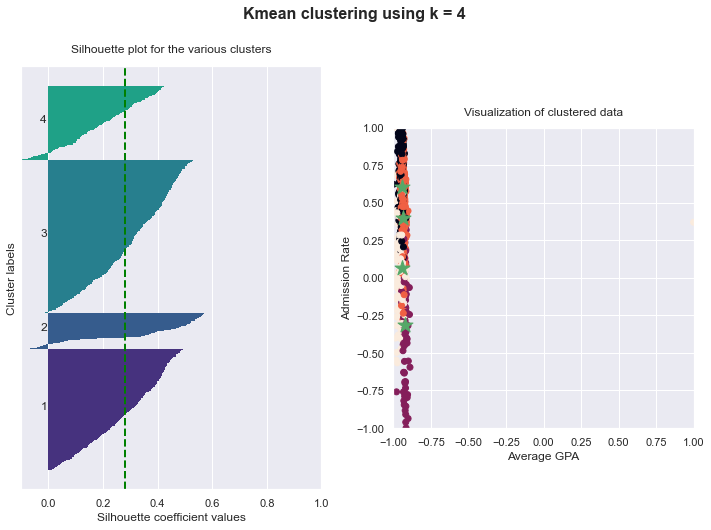

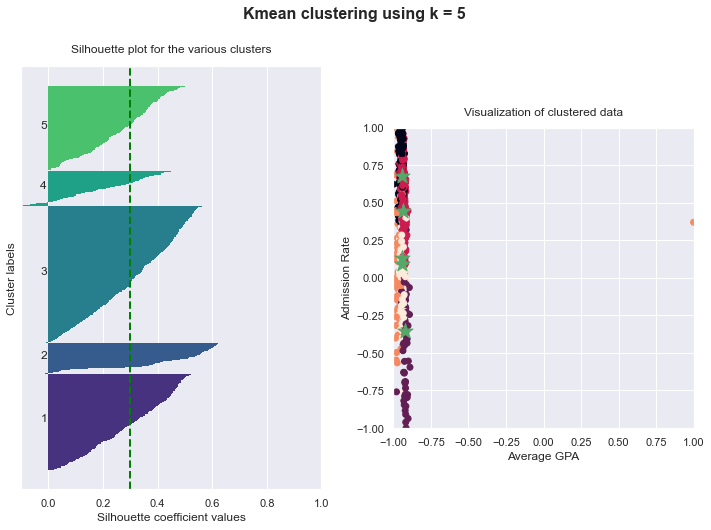

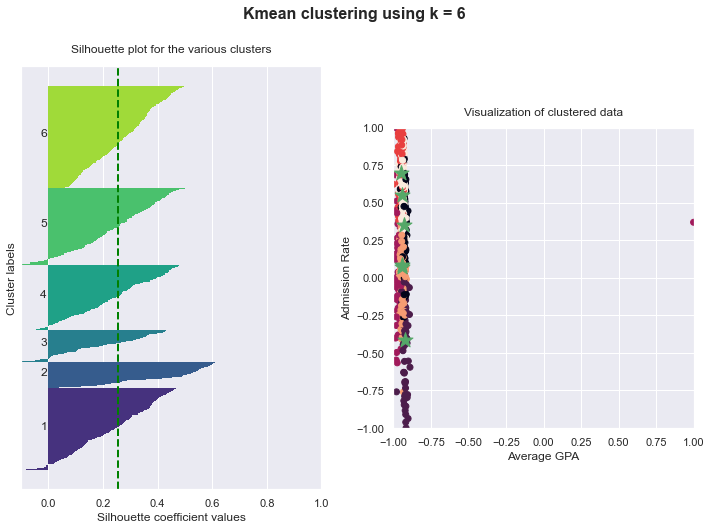

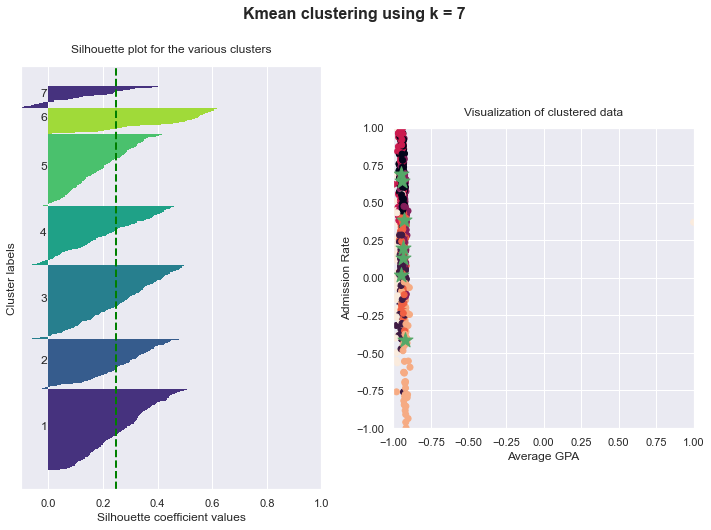

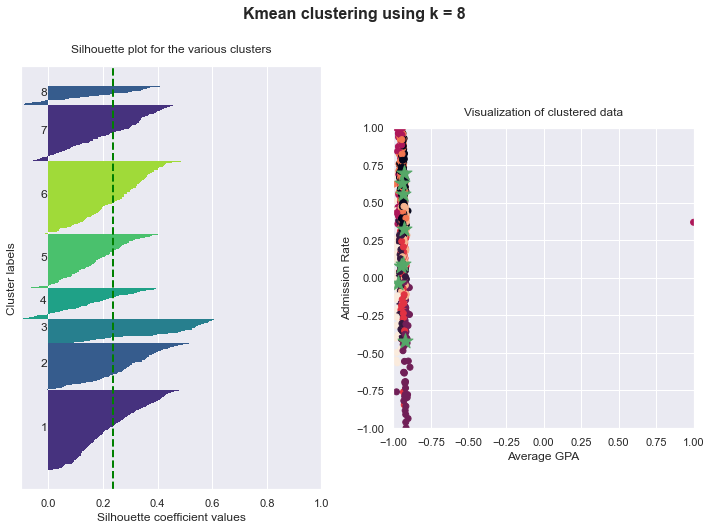

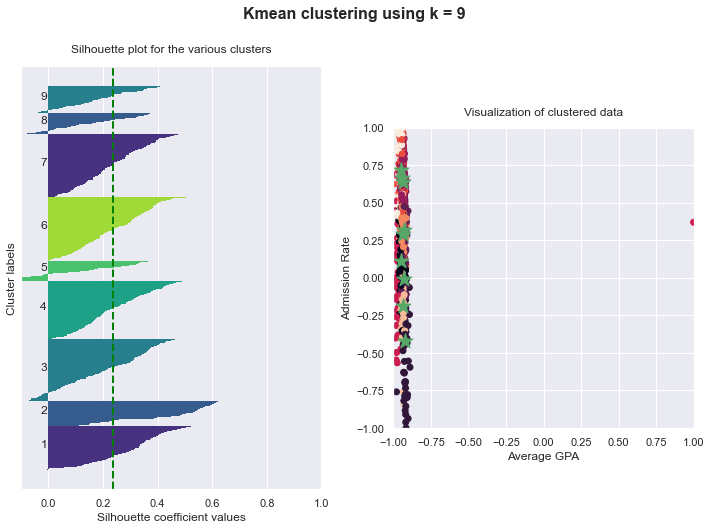

In [53]:
sns.set_style("darkgrid")
sns.set_palette("viridis")

X_std = MinMaxScaler(feature_range=(-1, 1)).fit_transform(NotImpt)
def kmeans_silhouette(dat):
    for i, k in enumerate(list(range(3, 10))):
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        fig.set_size_inches(10, 7)

        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(dat)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(dat, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02)

        # Scatter plot of data colored with labels
        ax2.scatter(dat[:, 1], dat[:, 0], c=labels)
        ax2.scatter(centroids[:, 1], centroids[:, 0], marker='*', c='g', s=250)
        ax2.set_xlim([-1, 1])
        ax2.set_ylim([-1, 1])
        ax2.set_xlabel('Average GPA')
        ax2.set_ylabel('Admission Rate')
        ax2.set_title('Visualization of clustered data', y=1.02)
        ax2.set_aspect('equal')
        plt.tight_layout()
        plt.suptitle(f'Kmean clustering using k = {k}',
                  fontsize=16, fontweight='semibold', y=1.05)
kmeans_silhouette(X_std)

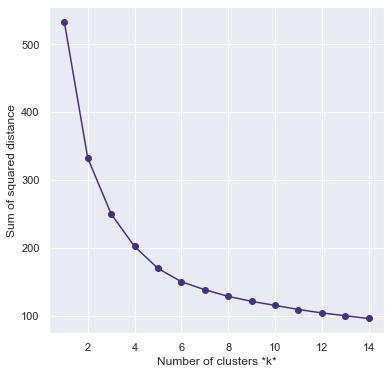

In [54]:
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [55]:
kmeans_NotImpt = NotImpt.copy()
kmeans = KMeans(n_clusters=7, random_state=32).fit(X_std)
kmeans_NotImpt['tierKey'] = kmeans.labels_ #kmeans.predict(data_norm)
#kmeans_result.to_csv('kmeans_result.csv', index=False)
# Cluster membership
kmean_NotImpt_dict = {}
memb = pd.Series(kmeans.labels_, index=kmeans_NotImpt.index)
for key, item in memb.groupby(memb):
    kmean_NotImpt_dict[key] = item.index.tolist()
    #print(key, ': ', ', '.join(item.index))

In [56]:
kmeans_NotImpt

,Average_Admission,Average_GPA,Average_ACT,gradRate,medEarning,defaultRate,tierKey
arcoName,,,,,,,
Abilene Christian University,0.60030,3.625,23.75,0.67,35600.0,0.05,2
Adams State University,0.98940,3.125,19.75,0.27,26700.0,0.10,4
Adelphi University,0.73560,3.505,24.75,0.70,43500.0,0.04,1
Adrian College,0.57865,3.230,22.25,0.45,32100.0,0.08,6
Agnes Scott College,0.65290,3.790,27.00,0.69,30800.0,0.05,1
...,...,...,...,...,...,...,...
Yeshiva University,0.58910,3.445,26.00,0.83,41300.0,0.02,1
York College,0.54245,3.070,21.25,0.51,28400.0,0.17,6
York College of Pennsylvania,0.69450,3.480,22.50,0.59,38100.0,0.04,0


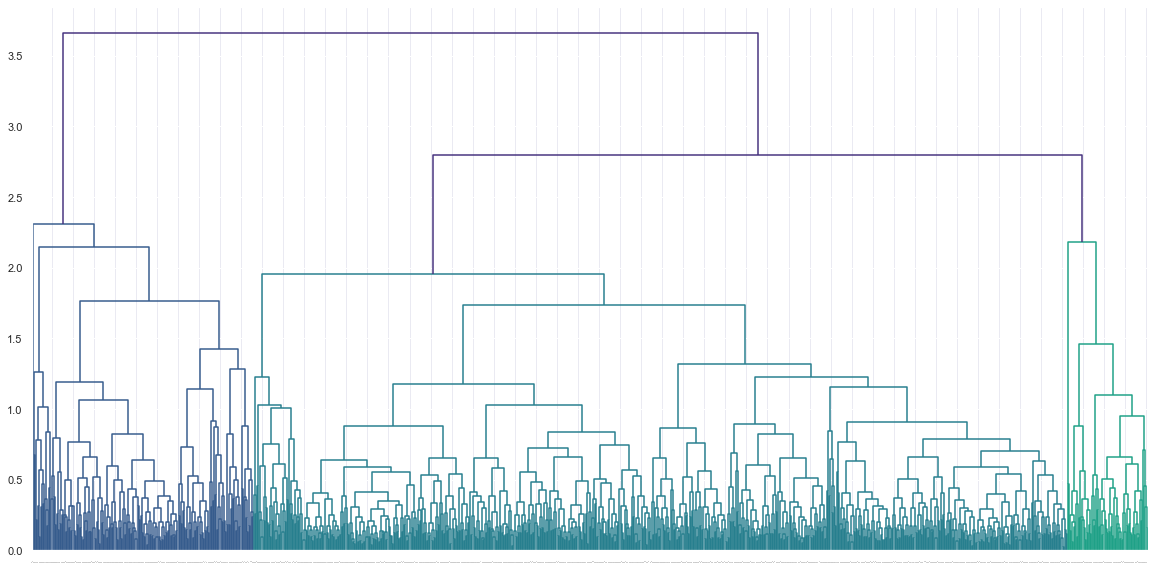

In [57]:
sns.set_style("darkgrid")

# Calculate the linkage: mergings
mergings = linkage(X_std, method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(20,10))
dendrogram(mergings,
           #labels="",
           leaf_rotation=90,
           leaf_font_size=1,
)
plt.show()

In [58]:
kmeans_NotImpt.groupby('tierKey').mean()

,Average_Admission,Average_GPA,Average_ACT,gradRate,medEarning,defaultRate
tierKey,,,,,,
0,0.804326,3.401455,22.805037,0.589104,36391.044776,0.053246
1,0.710059,3.623251,25.996305,0.740493,41487.684729,0.029360
2,0.564641,3.495651,23.334475,0.599178,34228.082192,0.056027
3,0.326178,3.811338,30.281690,0.862958,47714.084507,0.018873
4,0.869806,3.237331,20.771959,0.400000,31770.945946,0.092432
5,0.563426,3.463176,17.980856,0.284595,25432.432432,0.181622
6,0.577381,3.275229,20.688453,0.434183,32083.660131,0.089085


In [60]:
d = {3: 'ELITE', 5: 'MOST_SEL', 2: 'HIGH_SEL', 6: 'MED_SEL', 0: 'SEL', 1: 'LESS_SEL', 4: 'NON_SEL'}
d

{3: 'ELITE',
 5: 'MOST_SEL',
 2: 'HIGH_SEL',
 6: 'MED_SEL',
 0: 'SEL',
 1: 'LESS_SEL',
 4: 'NON_SEL'}

In [62]:
kmeans_NotImpt['newTier'] = kmeans_NotImpt['tierKey'].map(d)

In [63]:
kmeans_NotImpt

,Average_Admission,Average_GPA,Average_ACT,gradRate,medEarning,defaultRate,tierKey,newTier
arcoName,,,,,,,,
Abilene Christian University,0.60030,3.625,23.75,0.67,35600.0,0.05,2,HIGH_SEL
Adams State University,0.98940,3.125,19.75,0.27,26700.0,0.10,4,NON_SEL
Adelphi University,0.73560,3.505,24.75,0.70,43500.0,0.04,1,LESS_SEL
Adrian College,0.57865,3.230,22.25,0.45,32100.0,0.08,6,MED_SEL
Agnes Scott College,0.65290,3.790,27.00,0.69,30800.0,0.05,1,LESS_SEL
...,...,...,...,...,...,...,...,...
Yeshiva University,0.58910,3.445,26.00,0.83,41300.0,0.02,1,LESS_SEL
York College,0.54245,3.070,21.25,0.51,28400.0,0.17,6,MED_SEL
York College of Pennsylvania,0.69450,3.480,22.50,0.59,38100.0,0.04,0,SEL


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6')]

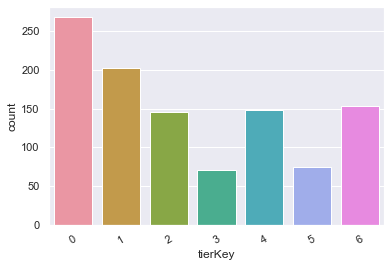

In [64]:
sns.set_style("darkgrid")
ax = sns.countplot(x="tierKey", data=kmeans_NotImpt) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

